# Pipeline for analyzing flow cytometry data

In [2]:
from FlowCytometryTools import *
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import glob
import seaborn as sns

import os
import sys

path = '/Users/andrewng/Documents/AHN_FlowTools/'
if not path in sys.path:
    sys.path.insert(1, path)
del path

from AHN_FlowTools import *

sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline

In [3]:
datadir = list()

datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/2018FeedbackPaper/ahn20180721_MATdeg/Plate1/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/2018FeedbackPaper/ahn20180721_MATdeg/Plate2/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/2018FeedbackPaper/ahn20180721_MATdeg/Plate3/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/2018FeedbackPaper/ahn20180721_MATdeg/Plate4/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/2018FeedbackPaper/ahn20180723_MATdeg/Plate1/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/2018FeedbackPaper/ahn20180724_MATdeg/Plate1/')


date = '20180721'

allfiles = {}
strains = ['Plate1','Plate2','Plate3','Plate4','Plate5','Plate6']

for i in range(len(datadir)):
    files = glob.glob(datadir[i] + '*.fcs')
    allfiles[strains[i]] = files

In [4]:
rows = ['A','B','C','D','E','F','G','H']
cols = ['01','02','03','04','05','06','07','08','09','10','11','12']

In [5]:
plateraw = pd.DataFrame(index = rows, columns = cols)

panelDict = {strain:plateraw for strain in strains}
allplates = pd.Panel(panelDict)

/Users/andrewng/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
for strain in strains:
    for f in allfiles[strain]:
        c = f[-10:-8]
        r = f[-11]
        call = r + c
        allplates[strain].set_value(r, c, FCMeasurement(ID = call, datafile = f))

/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [7]:
def FCdatastats(platesort,normalized=None,rows=None,cols=None,FITCthresh=None,FSCthresh=None):

    #Calculate the linear median, mean, and SD for each of the wells. Create two different Panels, one for FITC and one
    #for mCherry. In each Panel store a DataFrame containing the median, mean, SD, and CV

    if normalized is None:
        normalized = True
    if rows is None:
        rows = ['A','B','C','D','E','F','G','H']
    if cols is None:
        cols = ['01','02','03','04','05','06','07','08','09','10','11','12']
    if FITCthresh is None:
        FITCthresh = 100
    if FSCthresh is None:
        FSCthresh = 1000

    empty = pd.DataFrame(index = rows, columns = cols)

    FITCstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty, 'cv':empty})
    RFPstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty,'cv':empty})
    BFPstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty,'cv':empty})

    for row in rows:
        for col in cols:

            try:
                FCM = gate(platesort.loc[row,col],'FITC-H',FITCthresh)

                FCM2 = FCM[FCM['SSC-H'] > FSCthresh]
            except TypeError:
                continue

            try:
                if normalized == True:
                    FITC = FCM2['FITC-H']/FCM2['SSC-H']
                    RFP = FCM2['PE-Texas Red-H']/FCM2['SSC-H']
                    BFP = FCM2['DAPI-H']/FCM2['SSC-H']

                elif normalized == False:
                    FITC = FCM2['FITC-H']
                    RFP = FCM2['PE-Texas Red-H']
                    BFP = FCM2['DAPI-H']

                FITCstats.raw.set_value(row, col, FITC)
                FITCstats.med.set_value(row,col,FITC.median(axis=0))
                FITCstats.avg.set_value(row,col,FITC.mean(axis=0))
                FITCstats.sd.set_value(row,col,FITC.std(axis=0))
                FITCstats.cv.set_value(row,col,FITCstats.avg.loc[row,col]/FITCstats.sd.loc[row,col])

                RFPstats.raw.set_value(row, col, RFP)
                RFPstats.med.set_value(row,col,RFP.median(axis=0))
                RFPstats.avg.set_value(row,col,RFP.mean(axis=0))
                RFPstats.sd.set_value(row,col,RFP.std(axis=0))
                RFPstats.cv.set_value(row,col,RFPstats.avg.loc[row,col]/RFPstats.sd.loc[row,col])

                BFPstats.raw.set_value(row, col, BFP)
                BFPstats.med.set_value(row,col,BFP.median(axis=0))
                BFPstats.avg.set_value(row,col,BFP.mean(axis=0))
                BFPstats.sd.set_value(row,col,BFP.std(axis=0))
                BFPstats.cv.set_value(row,col,BFPstats.avg.loc[row,col]/BFPstats.sd.loc[row,col])
                
            except (AttributeError, TypeError):
                continue

    return [FITCstats, RFPstats, BFPstats]


In [8]:
FITCnorm = {}
RFPnorm = {}
BFPnorm = {}

for strain in strains: 
    [FITCnorm[strain], RFPnorm[strain],BFPnorm[strain]] = FCdatastats(allplates[strain],1,rows,cols,10,1000)


/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:45: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: FutureWarning: set_value is deprecated and will be remov

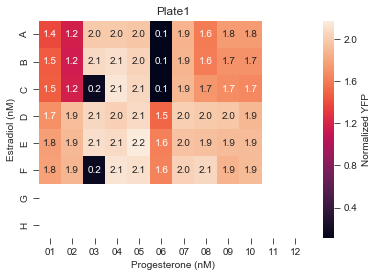

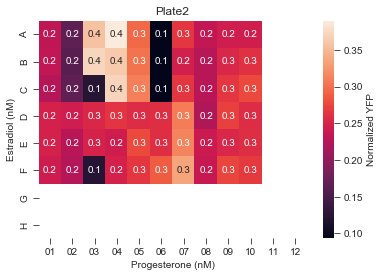

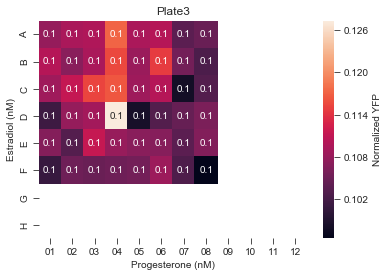

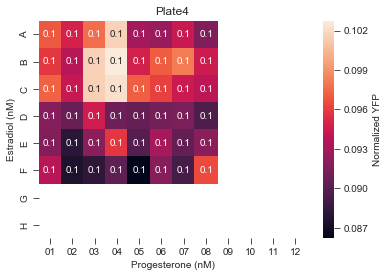

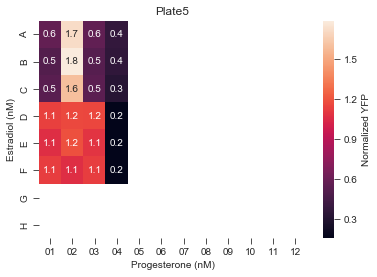

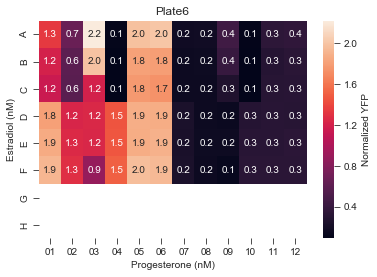

In [10]:
for plate in strains:
    sns.heatmap(FITCnorm[plate].med.astype(float),annot=True,fmt='.1f',cbar_kws={'label': 'Normalized YFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'YFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

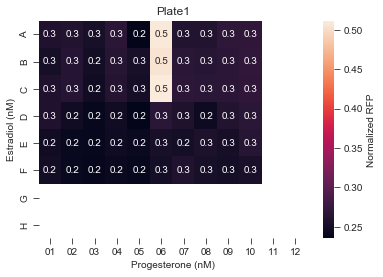

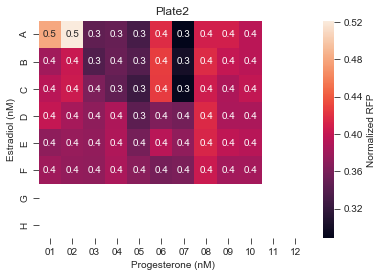

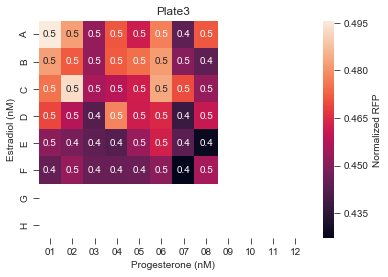

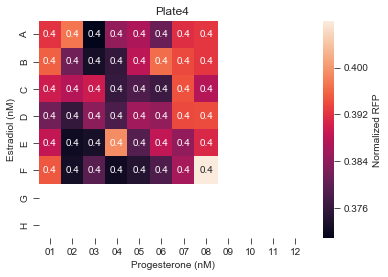

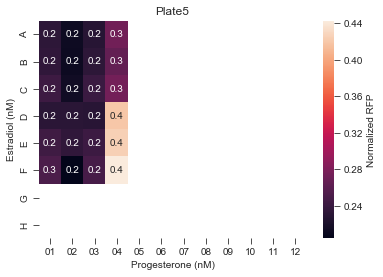

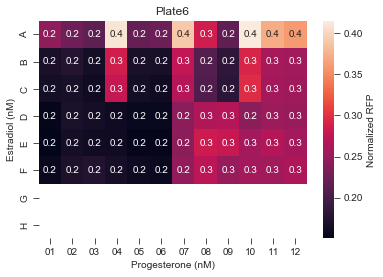

In [30]:
for plate in strains:
    sns.heatmap(RFPnorm[plate].med.astype(float),annot=True,fmt='.1f',cbar_kws={'label': 'Normalized RFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'RFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

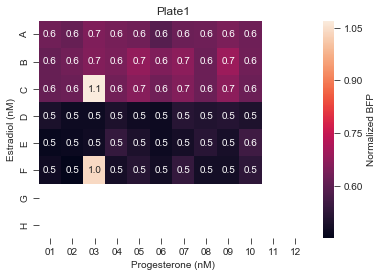

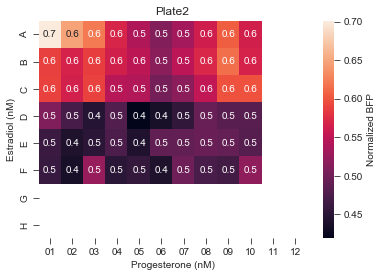

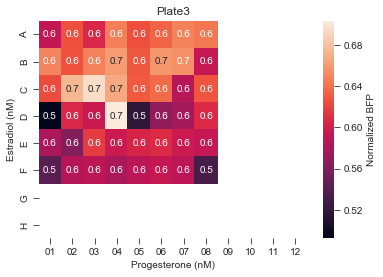

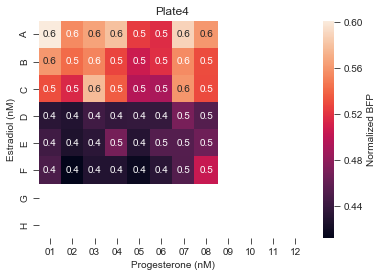

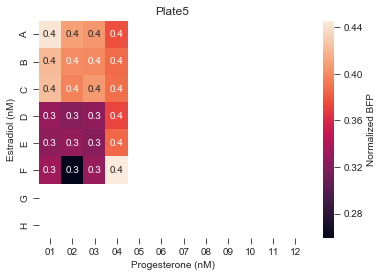

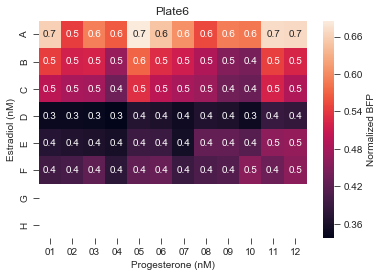

In [31]:
for plate in strains:
    sns.heatmap(BFPnorm[plate].med.astype(float),annot=True,fmt='.1f',cbar_kws={'label': 'Normalized BFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'BFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

## Work up histograms of the data in a 96 well plate format

/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda

/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda

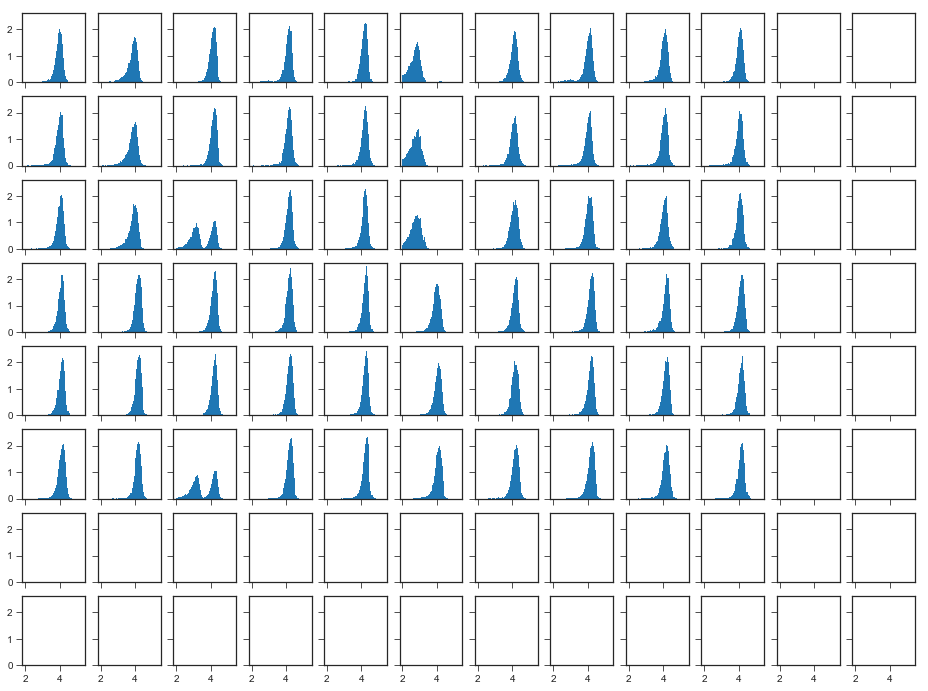

/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda

/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda

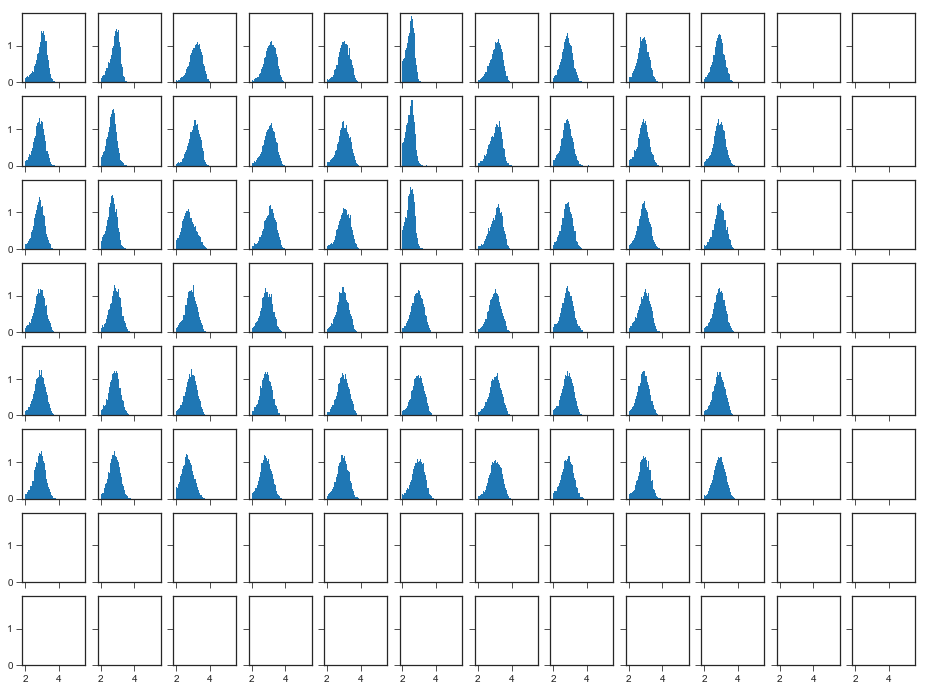

/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda

/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda

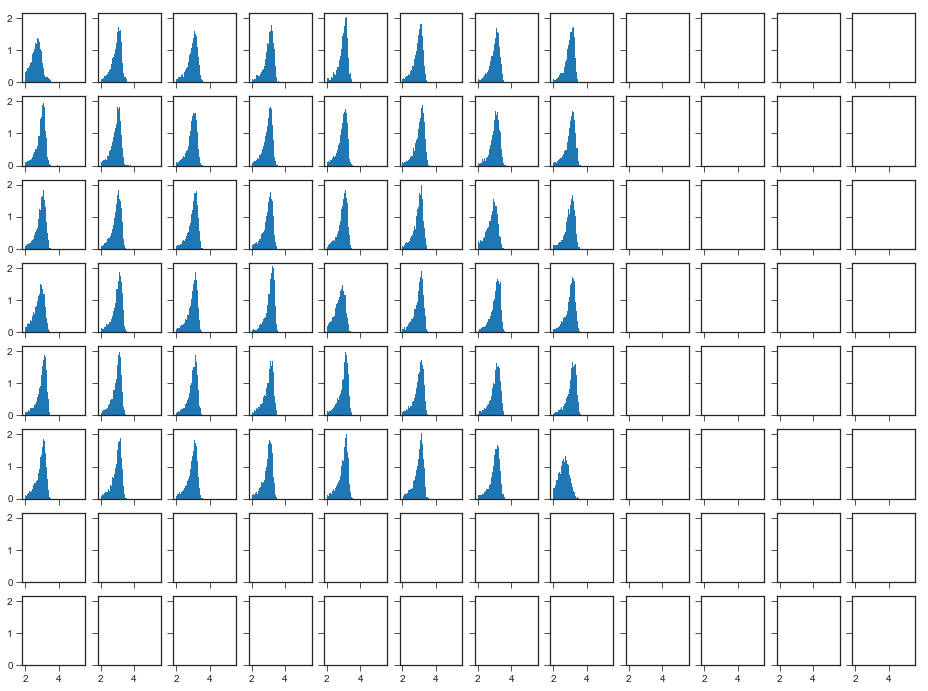

/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda

/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/andrewng/anaconda

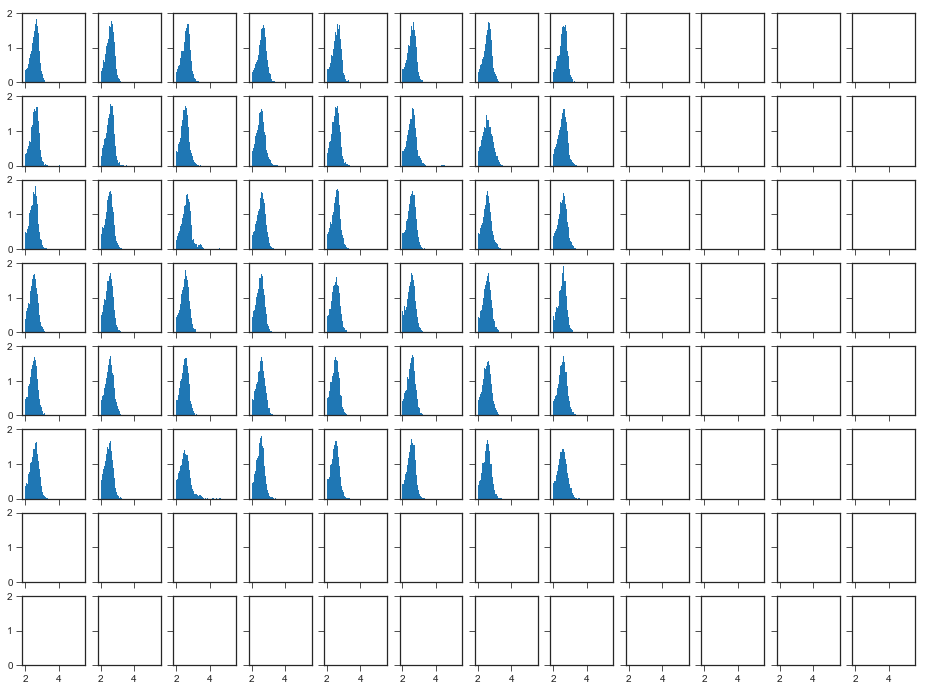

In [11]:
for plate in strains:
    FITCclean = pd.DataFrame(index = rows, columns = cols)
    logFITCclean = pd.DataFrame(index = rows, columns = cols)

    for row in rows:
        for col in cols:
            try:
                FITCclean.loc[row,col] = cleandata(allplates[plate].loc[row,col].data['FITC-A'].values,100)
                logFITCclean.loc[row,col] = np.log10(cleandata(allplates[plate].loc[row,col].data['FITC-A'].values,100))
            except:
                continue

    FITC_bincenter = pd.DataFrame(index = rows, columns = cols)
    FITC_histy = pd.DataFrame(index = rows, columns = cols)

    fig, ax = plt.subplots(8, 12,sharex = True, sharey = True, figsize=(16,12))

    for i in range(8):
        for j in range(12):
            try:
                FITC_histy.iloc[i,j],FITC_bincenter.iloc[i,j] = ax[i,j].hist(logFITCclean.iloc[i,j][~np.isnan(logFITCclean.iloc[i,j])],50,normed=1)
            except:
                continue

    dest = date + plate + 'fullhist'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

# Process data into arrays, calculate averages and standard deviations

In [9]:
MATstrs = ['STE20','STE11','MSG5-cyto','MSG5-nuc','PTP3','STE12','DIG1','DIG2','WT-cyto','WT-nuc','FUS3-cyto','FUS3-nuc']
conds = ['Pg','noPg']

In [10]:
#Average across the triplicate plates
HiFITC = pd.DataFrame(columns = MATstrs)
LoFITC = pd.DataFrame(columns = MATstrs)

HiFITCavg = pd.DataFrame(columns = MATstrs)
LoFITCavg = pd.DataFrame(columns = MATstrs)

HiFITCstd = pd.DataFrame(columns = MATstrs)
LoFITCstd = pd.DataFrame(columns = MATstrs)

for j, r in enumerate(conds):
    for i, c in enumerate(MATstrs[0:10]):
        #Save the array
        HiFITC.loc[r, c] = [FITCnorm['Plate1'].med.iloc[3*j,i],FITCnorm['Plate1'].med.iloc[3*j+1,i],FITCnorm['Plate1'].med.iloc[3*j+2,i]]
        LoFITC.loc[r, c] = [FITCnorm['Plate2'].med.iloc[3*j,i],FITCnorm['Plate2'].med.iloc[3*j+1,i],FITCnorm['Plate2'].med.iloc[3*j+2,i]]

        #Calculate the stats
        HiFITCavg.loc[r, c] = np.mean([FITCnorm['Plate1'].med.iloc[3*j,i],FITCnorm['Plate1'].med.iloc[3*j+1,i],FITCnorm['Plate1'].med.iloc[3*j+2,i]])
        LoFITCavg.loc[r, c] = np.mean([FITCnorm['Plate2'].med.iloc[3*j,i],FITCnorm['Plate2'].med.iloc[3*j+1,i],FITCnorm['Plate2'].med.iloc[3*j+2,i]])

        HiFITCstd.loc[r, c] = np.std([FITCnorm['Plate1'].med.iloc[3*j,i],FITCnorm['Plate1'].med.iloc[3*j+1,i],FITCnorm['Plate1'].med.iloc[3*j+2,i]])
        LoFITCstd.loc[r, c] = np.std([FITCnorm['Plate2'].med.iloc[3*j,i],FITCnorm['Plate2'].med.iloc[3*j+1,i],FITCnorm['Plate2'].med.iloc[3*j+2,i]])

In [11]:
#Save the array
HiFITC.loc['Pg','MSG5-cyto'] = [FITCnorm['Plate1'].med.iloc[0,4],FITCnorm['Plate1'].med.iloc[1,4]]
HiFITC.loc['noPg','MSG5-cyto'] = [FITCnorm['Plate1'].med.iloc[3,4],FITCnorm['Plate1'].med.iloc[4,4]]

LoFITC.loc['Pg','MSG5-cyto'] = [FITCnorm['Plate2'].med.iloc[0,4],FITCnorm['Plate2'].med.iloc[1,4]]
LoFITC.loc['noPg','MSG5-cyto'] = [FITCnorm['Plate2'].med.iloc[3,4],FITCnorm['Plate2'].med.iloc[4,4]]

#Calculate the stats
HiFITCavg.loc['Pg','MSG5-cyto'] = np.mean([FITCnorm['Plate1'].med.iloc[0,4],FITCnorm['Plate1'].med.iloc[1,4]])
HiFITCavg.loc['noPg','MSG5-cyto'] = np.mean([FITCnorm['Plate1'].med.iloc[3,4],FITCnorm['Plate1'].med.iloc[4,4]])

LoFITCavg.loc['Pg','MSG5-cyto'] = np.mean([FITCnorm['Plate2'].med.iloc[0,4],FITCnorm['Plate2'].med.iloc[1,4]])
LoFITCavg.loc['noPg','MSG5-cyto'] = np.mean([FITCnorm['Plate2'].med.iloc[3,4],FITCnorm['Plate2'].med.iloc[4,4]])

HiFITCstd.loc['Pg','MSG5-cyto'] = np.std([FITCnorm['Plate1'].med.iloc[0,4],FITCnorm['Plate1'].med.iloc[1,4]])
HiFITCstd.loc['noPg','MSG5-cyto'] = np.std([FITCnorm['Plate1'].med.iloc[3,4],FITCnorm['Plate1'].med.iloc[4,4]])

LoFITCstd.loc['Pg','MSG5-cyto'] = np.std([FITCnorm['Plate2'].med.iloc[0,4],FITCnorm['Plate2'].med.iloc[1,4]])
LoFITCstd.loc['noPg','MSG5-cyto'] = np.std([FITCnorm['Plate2'].med.iloc[3,4],FITCnorm['Plate2'].med.iloc[4,4]])

In [12]:
#Save the array
HiFITC.loc['Pg','FUS3-nuc'] = [FITCnorm['Plate5'].med.iloc[0,1],FITCnorm['Plate5'].med.iloc[1,1],FITCnorm['Plate5'].med.iloc[2,1]]
HiFITC.loc['noPg','FUS3-nuc'] = [FITCnorm['Plate5'].med.iloc[3,1],FITCnorm['Plate5'].med.iloc[4,1],FITCnorm['Plate5'].med.iloc[5,1]]

LoFITC.loc['Pg','FUS3-nuc'] = [FITCnorm['Plate5'].med.iloc[0,3],FITCnorm['Plate5'].med.iloc[1,3],FITCnorm['Plate5'].med.iloc[2,3]]
LoFITC.loc['noPg','FUS3-nuc'] = [FITCnorm['Plate5'].med.iloc[3,3],FITCnorm['Plate5'].med.iloc[4,3],FITCnorm['Plate5'].med.iloc[5,3]]

HiFITC.loc['Pg','FUS3-cyto'] = [FITCnorm['Plate6'].med.iloc[0,1],FITCnorm['Plate6'].med.iloc[1,1],FITCnorm['Plate6'].med.iloc[2,1]]
HiFITC.loc['noPg','FUS3-cyto'] = [FITCnorm['Plate6'].med.iloc[3,1],FITCnorm['Plate6'].med.iloc[4,1],FITCnorm['Plate6'].med.iloc[5,1]]

LoFITC.loc['Pg','FUS3-cyto'] = [FITCnorm['Plate6'].med.iloc[0,7],FITCnorm['Plate6'].med.iloc[1,7],FITCnorm['Plate6'].med.iloc[2,7]]
LoFITC.loc['noPg','FUS3-cyto'] = [FITCnorm['Plate6'].med.iloc[3,7],FITCnorm['Plate6'].med.iloc[4,7],FITCnorm['Plate6'].med.iloc[5,7]]

#Averages
HiFITCavg.loc['Pg','FUS3-nuc'] = np.mean([FITCnorm['Plate5'].med.iloc[0,1],FITCnorm['Plate5'].med.iloc[1,1],FITCnorm['Plate5'].med.iloc[2,1]])
HiFITCavg.loc['noPg','FUS3-nuc'] = np.mean([FITCnorm['Plate5'].med.iloc[3,1],FITCnorm['Plate5'].med.iloc[4,1],FITCnorm['Plate5'].med.iloc[5,1]])

LoFITCavg.loc['Pg','FUS3-nuc'] = np.mean([FITCnorm['Plate5'].med.iloc[0,3],FITCnorm['Plate5'].med.iloc[1,3],FITCnorm['Plate5'].med.iloc[2,3]])
LoFITCavg.loc['noPg','FUS3-nuc'] = np.mean([FITCnorm['Plate5'].med.iloc[3,3],FITCnorm['Plate5'].med.iloc[4,3],FITCnorm['Plate5'].med.iloc[5,3]])

HiFITCavg.loc['Pg','FUS3-cyto'] = np.mean([FITCnorm['Plate6'].med.iloc[0,1],FITCnorm['Plate6'].med.iloc[1,1],FITCnorm['Plate6'].med.iloc[2,1]])
HiFITCavg.loc['noPg','FUS3-cyto'] = np.mean([FITCnorm['Plate6'].med.iloc[3,1],FITCnorm['Plate6'].med.iloc[4,1],FITCnorm['Plate6'].med.iloc[5,1]])

LoFITCavg.loc['Pg','FUS3-cyto'] = np.mean([FITCnorm['Plate6'].med.iloc[0,7],FITCnorm['Plate6'].med.iloc[1,7],FITCnorm['Plate6'].med.iloc[2,7]])
LoFITCavg.loc['noPg','FUS3-cyto'] = np.mean([FITCnorm['Plate6'].med.iloc[3,7],FITCnorm['Plate6'].med.iloc[4,7],FITCnorm['Plate6'].med.iloc[5,7]])

#Standard Deviations
HiFITCstd.loc['Pg','FUS3-nuc'] = np.std([FITCnorm['Plate5'].med.iloc[0,1],FITCnorm['Plate5'].med.iloc[1,1],FITCnorm['Plate5'].med.iloc[2,1]])
HiFITCstd.loc['noPg','FUS3-nuc'] = np.std([FITCnorm['Plate5'].med.iloc[3,1],FITCnorm['Plate5'].med.iloc[4,1],FITCnorm['Plate5'].med.iloc[5,1]])

LoFITCstd.loc['Pg','FUS3-nuc'] = np.std([FITCnorm['Plate5'].med.iloc[0,3],FITCnorm['Plate5'].med.iloc[1,3],FITCnorm['Plate5'].med.iloc[2,3]])
LoFITCstd.loc['noPg','FUS3-nuc'] = np.std([FITCnorm['Plate5'].med.iloc[3,3],FITCnorm['Plate5'].med.iloc[4,3],FITCnorm['Plate5'].med.iloc[5,3]])

HiFITCstd.loc['Pg','FUS3-cyto'] = np.std([FITCnorm['Plate6'].med.iloc[0,1],FITCnorm['Plate6'].med.iloc[1,1],FITCnorm['Plate6'].med.iloc[2,1]])
HiFITCstd.loc['noPg','FUS3-cyto'] = np.std([FITCnorm['Plate6'].med.iloc[3,1],FITCnorm['Plate6'].med.iloc[4,1],FITCnorm['Plate6'].med.iloc[5,1]])

LoFITCstd.loc['Pg','FUS3-cyto'] = np.std([FITCnorm['Plate6'].med.iloc[0,7],FITCnorm['Plate6'].med.iloc[1,7],FITCnorm['Plate6'].med.iloc[2,7]])
LoFITCstd.loc['noPg','FUS3-cyto'] = np.std([FITCnorm['Plate6'].med.iloc[3,7],FITCnorm['Plate6'].med.iloc[4,7],FITCnorm['Plate6'].med.iloc[5,7]])


In [14]:
pubstrs = ['WT-cyto','STE20','STE11','FUS3-cyto','FUS3-nuc','STE12']

In [15]:
pubHiFITC = pd.DataFrame(index = conds, columns = pubstrs)
pubLoFITC = pd.DataFrame(index = conds, columns = pubstrs)

pubHiFITCavg = pd.DataFrame(index = conds, columns = pubstrs)
pubLoFITCavg = pd.DataFrame(index = conds, columns = pubstrs)

pubHiFITCstd = pd.DataFrame(index = conds, columns = pubstrs)
pubLoFITCstd = pd.DataFrame(index = conds, columns = pubstrs)

for s in pubstrs:
    pubHiFITC.loc[:,s] = HiFITC.loc[:,s]
    pubLoFITC.loc[:,s] = LoFITC.loc[:,s]
    
    pubHiFITCavg.loc[:,s] = HiFITCavg.loc[:,s]
    pubLoFITCavg.loc[:,s] = LoFITCavg.loc[:,s]
    
    pubHiFITCstd.loc[:,s] = HiFITCstd.loc[:,s]
    pubLoFITCstd.loc[:,s] = LoFITCstd.loc[:,s]

# Calculate p-values

In [18]:
from scipy.stats import ttest_ind

statHiFITC = pd.Series(index = MATstrs)

for i in MATstrs:
    stat, p  = ttest_ind(HiFITC.loc['Pg',i],HiFITC.loc['noPg',i])
    statHiFITC[i] = p

In [19]:
stat, p1 = ttest_ind(HiFITC.loc['Pg','WT-cyto'],HiFITC.loc['noPg','WT-cyto'])
stat, p2 = ttest_ind(HiFITC.loc['Pg','WT-cyto'],HiFITC.loc['Pg','STE20'])
stat, p3 = ttest_ind(HiFITC.loc['Pg','WT-cyto'],HiFITC.loc['noPg','STE20'])

stat, p4 = ttest_ind(HiFITC.loc['noPg','WT-cyto'],HiFITC.loc['Pg','STE20'])
stat, p5 = ttest_ind(HiFITC.loc['noPg','WT-cyto'],HiFITC.loc['noPg','STE20'])

stat, p6 = ttest_ind(HiFITC.loc['Pg','STE20'],HiFITC.loc['noPg','STE20'])

In [20]:
#Show p-values
print [p1,p2,p3,p4,p5,p6]

[0.004525968033214181, 0.001650976998515037, 0.32841550602900854, 0.0003276700688993297, 0.01174106319863674, 0.0013652084793803027]


In [21]:
statHiFITC

STE20        1.365208e-03
STE11        8.919514e-07
MSG5-cyto    1.784311e-01
MSG5-nuc     9.856870e-01
PTP3         6.772760e-02
STE12        3.518892e-06
DIG1         1.063898e-02
DIG2         3.227585e-03
WT-cyto      4.525968e-03
WT-nuc       2.649900e-03
FUS3-cyto    3.658787e-05
FUS3-nuc     1.122371e-03
dtype: float64

# Plot Data

In [22]:
space = np.array([0.2,0.5,0.8])

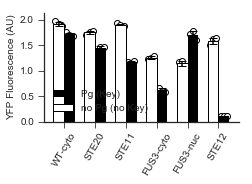

In [33]:
ind = np.arange(6)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(3.5,2))

rects2 = ax.bar(ind, pubHiFITCavg.loc['noPg'], width, color='w', edgecolor='k', yerr=pubHiFITCstd.loc['noPg'], capsize = 4)
rects1 = ax.bar(ind + width, pubHiFITCavg.loc['Pg'], width, color='k', yerr=pubHiFITCstd.loc['Pg'], capsize = 4)

for i, strain in enumerate(pubstrs):
    ax.scatter(space*width+i-width/2, pubHiFITC.loc['noPg',strain], color='w', edgecolor='k',markersize=)
    ax.scatter(space*width+i+width/2, pubHiFITC.loc['Pg',strain], color='w', edgecolor='k')
  
# add some text for labels, title and axes ticks
ax.set_ylabel('YFP Fluorescence (AU)')
#ax.set_yscale('log')
#ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(pubstrs, rotation = 60)

ax.legend((rects1[0], rects2[0]), ('Pg (Key)', 'no Pg (no Key)'))

sns.despine()
dest = date + 'pubHiAlphaYFPdots'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

In [23]:
# Rearrange data to make barplot prettier

cleanstrs = ['WT-cyto','WT-nuc','STE20','STE11','FUS3-cyto','FUS3-nuc','MSG5-nuc','PTP3','STE12','DIG1','DIG2']

cleanHiFITC = pd.DataFrame(index = conds, columns = cleanstrs)
cleanLoFITC = pd.DataFrame(index = conds, columns = cleanstrs)

cleanHiFITCavg = pd.DataFrame(index = conds, columns = cleanstrs)
cleanLoFITCavg = pd.DataFrame(index = conds, columns = cleanstrs)

cleanHiFITCstd = pd.DataFrame(index = conds, columns = cleanstrs)
cleanLoFITCstd = pd.DataFrame(index = conds, columns = cleanstrs)

for s in cleanstrs:
    cleanHiFITC.loc[:,s] = HiFITC.loc[:,s]
    cleanLoFITC.loc[:,s] = LoFITC.loc[:,s]
    
    cleanHiFITCavg.loc[:,s] = HiFITCavg.loc[:,s]
    cleanLoFITCavg.loc[:,s] = LoFITCavg.loc[:,s]
    
    cleanHiFITCstd.loc[:,s] = HiFITCstd.loc[:,s]
    cleanLoFITCstd.loc[:,s] = LoFITCstd.loc[:,s]

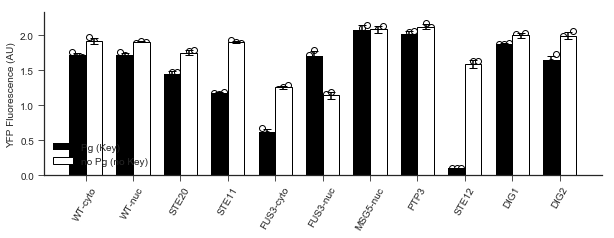

In [37]:
ind = np.arange(11)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(10,3))
rects1 = ax.bar(ind, cleanHiFITCavg.loc['Pg'], width, color='k', yerr=cleanHiFITCstd.loc['Pg'], capsize = 4)
rects2 = ax.bar(ind + width, cleanHiFITCavg.loc['noPg'], width, color='w', edgecolor='k', yerr=cleanHiFITCstd.loc['noPg'], capsize = 4)

for i, strain in enumerate(cleanstrs):
    ax.scatter(space*width+i-width/2, cleanHiFITC.loc['Pg',strain], color='w', edgecolor='k')
    ax.scatter(space*width+i+width/2, cleanHiFITC.loc['noPg',strain], color='w', edgecolor='k')

# add some text for labels, title and axes ticks
ax.set_ylabel('YFP Fluorescence (AU)')
#ax.set_yscale('log')
#ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(cleanstrs, rotation = 60)

ax.legend((rects1[0], rects2[0]), ('Pg (Key)', 'no Pg (no Key)'))

sns.despine()
dest = date + 'HiAlphaYFPdot'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

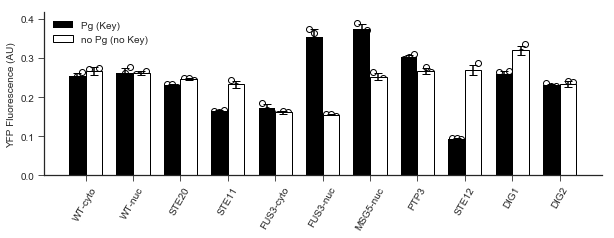

In [25]:
ind = np.arange(11)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(10,3))
rects1 = ax.bar(ind, cleanLoFITCavg.loc['Pg'], width, color='k', yerr=cleanLoFITCstd.loc['Pg'], capsize = 4)
rects2 = ax.bar(ind + width, cleanLoFITCavg.loc['noPg'], width, color='w', edgecolor='k', yerr=cleanLoFITCstd.loc['noPg'], capsize = 4)

for i, strain in enumerate(cleanstrs):
    ax.scatter(space*width+i-width/2, cleanLoFITC.loc['Pg',strain], color='w', edgecolor='k')
    ax.scatter(space*width+i+width/2, cleanLoFITC.loc['noPg',strain], color='w', edgecolor='k')
    
# add some text for labels, title and axes ticks
ax.set_ylabel('YFP Fluorescence (AU)')
#ax.set_yscale('log')
#ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(cleanstrs, rotation = 60)

ax.legend((rects1[0], rects2[0]), ('Pg (Key)', 'no Pg (no Key)'))

sns.despine()
dest = date + 'LoAlphaYFPdot'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

In [ ]:
#Average across the triplicate plates

ratioHiFITCavg = pd.DataFrame(columns = MATstrs)
ratioLoFITCavg = pd.DataFrame(columns = MATstrs)

ratioHiFITCstd = pd.DataFrame(columns = MATstrs)
ratioLoFITCstd = pd.DataFrame(columns = MATstrs)

for i, c in enumerate(MATstrs):
    ratioHiFITCavg.set_value(c, np.mean([FITCnorm['Plate1'].med.iloc[0,i]/FITCnorm['Plate1'].med.iloc[3,i],FITCnorm['Plate1'].med.iloc[3*j+1,i],FITCnorm['Plate1'].med.iloc[3*j+2,i]]))
    ratioLoFITCavg.set_value(c, np.mean([FITCnorm['Plate2'].med.iloc[3*j,i],FITCnorm['Plate2'].med.iloc[3*j+1,i],FITCnorm['Plate2'].med.iloc[3*j+2,i]]))

    ratioHiFITCstd.set_value(c, np.std([FITCnorm['Plate1'].med.iloc[3*j,i],FITCnorm['Plate1'].med.iloc[3*j+1,i],FITCnorm['Plate1'].med.iloc[3*j+2,i]]))
    ratioLoFITCstd.set_value(c, np.std([FITCnorm['Plate2'].med.iloc[3*j,i],FITCnorm['Plate2'].med.iloc[3*j+1,i],FITCnorm['Plate2'].med.iloc[3*j+2,i]]))

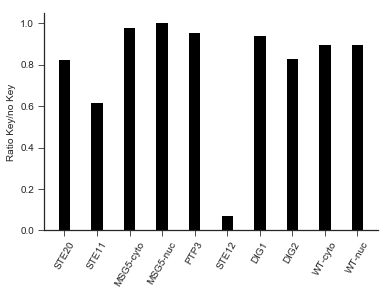

In [43]:
ind = np.arange(10)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, HiFITCavg.loc['Pg']/HiFITCavg.loc['noPg'], width, color='k')

# add some text for labels, title and axes ticks
ax.set_ylabel('Ratio Key/no Key')
#ax.set_yscale('log')
#ax.set_title('Scores by group and gender')
ax.set_xticks(ind)
ax.set_xticklabels(MATstrs, rotation = 60)

#ax.legend((rects1[0], rects2[0]), ('Pg (Key)', 'no Pg (no Key)'))

sns.despine()
dest = date + 'HiAlphaYFPratio'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()